# Deep learning NER

In this notebook, we will discover two deep learning techniques for Named Entity Recognition (or NER).

- LSTM (Long Short Term Memory)
- Transformers


The generated **BIO** file by the script will be loaded as well as a corpus of lambda sentences that don't necessarily contain either an _arrival_ or _departure_ location.

Since the goal is to extract the locations from a user's query, the times in which random sentences might be inputted should be accounted for. Therefore, to stay rational with the frequency of that happening, the ratio will be $1:10$ for the lambda sentences which will be extracted from `data/french_text/1k_unlabeled_samples.txt`. In addition, more complex sentences where the **departure** and **arrival** locations are not in the same sentence. Their ratio will be the same as the unlabeled sentences.


In [1]:
from app.travel_resolver.libs.nlp import data_processing as dp

sentences, labels, vocab, unique_labels = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/10k_train_small_samples.bio"
)

[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [2]:
lambda_sentences, lambda_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/1k_train_unlabeled_samples.bio"
)

In [3]:
large_sentences, large_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/1k_train_large_samples.bio"
)

In [4]:
sentences = sentences + lambda_sentences + large_sentences
labels = labels + lambda_labels + large_labels

In [5]:
def process_sentences_and_labels(
    sentences,
    labels,
    rm_stopwords: bool = False,
    stemming: bool = True,
    return_tokens: bool = False,
):
    """
    Process the sentences and labels using the process_sentence function from the data_processing module.

    Args:
    sentences (list): List of sentences to process.
    labels (list): List of labels to process.
    rm_stopwords (bool): Whether to remove stopwords from the sentences.
    stemming (bool): Whether to apply stemming to the sentences.
    return_tokens (bool): Whether to return the tokens of the sentences.

    Returns:
    processed_sentences (list): List of processed sentences.
    processed_labels (list): List of processed labels.
    """
    processed_sentences = []
    processed_labels = []

    for sentence, label in zip(sentences, labels):
        sentence, label = dp.process_sentence(
            sentence,
            labels_to_adapt=label,
            rm_stopwords=rm_stopwords,
            stemming=stemming,
            return_tokens=return_tokens,
        )
        processed_sentences.append(sentence)
        processed_labels.append(label)

    return processed_sentences, processed_labels

In [6]:
processed_sentences, processed_labels = process_sentences_and_labels(
    sentences, labels, return_tokens=True
)

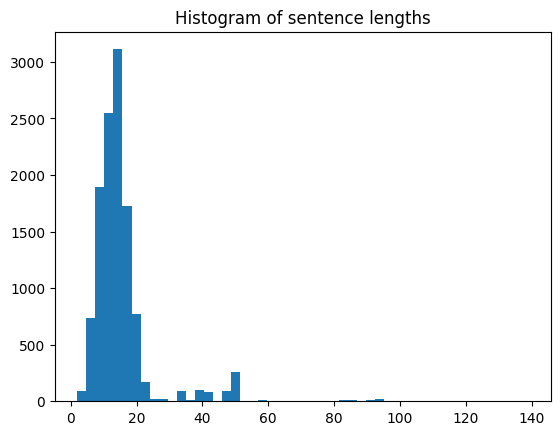

In [7]:
import matplotlib.pyplot as plt

plt.hist([len(sentence) for sentence in processed_sentences], bins=50)
plt.title("Histogram of sentence lengths")

plt.show()

In [8]:
"""
  This variable will control the maximum length of the sentence 
  as well as the embedding size
"""

MAX_LEN = 100

In [9]:
import tensorflow as tf


def encode_and_pad_sentence(sentence: str, vocab: list[str], max_length: int = MAX_LEN):
    """
    Encode a sentence into a list of integers

    Parameters:
    sentence (str): The sentence to encode
    vocab (list): The vocabulary

    Returns:
    list: The list of integers
    """
    encoded_sentence = [
        vocab.index(word) if word in vocab else vocab.index("<UNK>")
        for word in sentence
    ]

    return tf.keras.utils.pad_sequences(
        [encoded_sentence], maxlen=max_length, padding="post", value=0
    )[0]

In [10]:
get_vocab_from_corpus = lambda corpus: ["", "<UNK>"] + list(
    set([word for sentence in corpus for word in sentence])
)

In [11]:
vocab = get_vocab_from_corpus(processed_sentences)

In [12]:
encoded_sentences = [
    encode_and_pad_sentence(sentence, vocab) for sentence in processed_sentences
]

In [13]:
padded_labels = tf.keras.preprocessing.sequence.pad_sequences(
    processed_labels, maxlen=MAX_LEN, padding="post", value=-1
)

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((encoded_sentences, padded_labels))

dataset = dataset.shuffle(len(encoded_sentences), seed=42)

# Split the dataset into a training and testing dataset
train_dataset, test_dataset = tf.keras.utils.split_dataset(dataset, left_size=0.8)

2024-11-28 15:01:56.699366: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Masked loss and metrics

Before training the model, we need to create your own function to compute the accuracy. Tensorflow has built-in accuracy metrics but we cannot pass values to be ignored. This will impact the calculations, since we must remove the padded values.

Usually, the metric that inputs true labels and predicted labels and outputs how many times the predicted and true labels match is called accuracy. In some cases, however, there is one more step before getting the predicted labels. This may happen if, instead of passing the predicted labels, a vector of probabilities is passed. In such case, there is a need to perform an `argmax` for each prediction to find the appropriate predicted label. Such situations happen very often, therefore Tensorflow has a set of functions, with prefix `Sparse`, that performs this operation in the backend. Unfortunately, it does not provide values to ignore in the accuracy case. This is what you will work on now.

Note that the model's prediction has 3 axes:

- the number of examples (batch size)
- the number of words in each example (padded to be as long as the longest sentence in the batch)
- the number of possible targets (the 17 named entity tags).

Another important function is the loss function. In this case, we will use the Cross Entropy loss, but we need a multiclass implementation of it, also we may look for its Sparse version. Tensorflow has a SparseCategoricalCrossentropy loss function, which it is already imported by the name SparseCategoricalCrossEntropy.

SparseCategoricalCrossentropy: The Sparse Categorical Crossentropy Loss Function.

The arguments you will need:

1. `from_logits`: This indicates if the values are raw values or normalized values (probabilities). Since the last layer of the model finishes with a LogSoftMax call, the results are not normalized - they do not lie between 0 and 1.
2. `ignore_class`: This indicates which class should be ignored when computing the crossentropy. Remember that the class related to padding value is set to be 0.


In [15]:
class CustomSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, ignore_class=-1):
        super().__init__()
        self.from_logits = from_logits
        self.ignore_class = ignore_class

    def call(self, y_true, y_pred):
        # Ensure inputs are tensors
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)

        # Generate a mask that is False where y_true equals ignore_class and True elsewhere
        mask = tf.not_equal(y_true, self.ignore_class)

        # Use this mask to filter out ignored values from y_true and y_pred
        y_true_filtered = tf.boolean_mask(y_true, mask)
        y_pred_filtered = tf.boolean_mask(y_pred, mask)

        # Compute the sparse categorical crossentropy on filtered targets and predictions
        loss = tf.keras.losses.sparse_categorical_crossentropy(
            y_true_filtered, y_pred_filtered, from_logits=self.from_logits
        )

        # Return the mean loss value
        return tf.reduce_mean(loss)


def masked_loss(y_true, y_pred):
    """
    Calculate the masked sparse categorical cross-entropy loss.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.

    Returns:
    loss (tensor): Calculated loss.
    """

    # Calculate the loss for each item in the batch. Remember to pass the right arguments, as discussed above!
    loss_fn = CustomSparseCategoricalCrossentropy(from_logits=True, ignore_class=-1)
    # Use the previous defined function to compute the loss
    loss = loss_fn(y_true, y_pred)

    return loss

In [16]:
def masked_accuracy(y_true, y_pred):
    """
    Calculate masked accuracy for predicted labels.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.

    Returns:
    accuracy (tensor): Masked accuracy.
    """

    # Calculate the loss for each item in the batch.
    # We must always cast the tensors to the same type in order to use them in training. Since we will make divisions, it is safe to use tf.float32 data type.
    y_true = tf.cast(y_true, tf.float32)
    # Create the mask, i.e., the values that will be ignored
    mask = tf.not_equal(y_true, -1.0)

    mask = tf.cast(mask, tf.float32)

    # Perform argmax to get the predicted values
    y_pred_class = tf.math.argmax(y_pred, axis=-1)
    y_pred_class = tf.cast(y_pred_class, tf.float32)
    # Compare the true values with the predicted ones
    matches_true_pred = tf.equal(y_true, y_pred_class)
    matches_true_pred = tf.cast(matches_true_pred, tf.float32)
    # Multiply the acc tensor with the masks
    matches_true_pred *= mask

    # Compute masked accuracy (quotient between the total matches and the total valid values, i.e., the amount of non-masked values)
    masked_acc = tf.reduce_sum(matches_true_pred) / tf.reduce_sum(mask)

    return masked_acc

In addition, we will need a function that computes the accuracy of the model when it comes to the tagged entities. This will come in handy when comparing the performance of the models on sentences with different length. Because otherwise, using the `masked_accuracy` the score will be biases (because of the `O` token).


In [17]:
def entity_accuracy(y_true, y_pred):
    """
    Calculate the accuracy based on the entities. Which mean that correct `O` tags will not be taken into account.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.

    Returns:
    accuracy (tensor): Tag accuracy.
    """

    y_true = tf.cast(y_true, tf.float32)
    # We ignore the padding and the O tag
    mask = y_true > 0
    mask = tf.cast(mask, tf.float32)

    y_pred_class = tf.math.argmax(y_pred, axis=-1)
    y_pred_class = tf.cast(y_pred_class, tf.float32)

    matches_true_pred = tf.equal(y_true, y_pred_class)
    matches_true_pred = tf.cast(matches_true_pred, tf.float32)

    matches_true_pred *= mask

    masked_acc = tf.reduce_sum(matches_true_pred) / tf.reduce_sum(mask)

    print(tf.reduce_sum(matches_true_pred))

    print(tf.reduce_sum(mask))

    return masked_acc

## Eval Dataset


In [18]:
eval_sentences, eval_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/eval_small_samples.bio"
)

eval_unlabeled, eval_unlabeled_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/eval_unlabeled_samples.bio"
)

eval_large, eval_large_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/eval_large_samples.bio"
)

eval_short_sentences, eval_short_labels = process_sentences_and_labels(
    eval_sentences, eval_labels, return_tokens=True
)
eval_unlabeled_sentences, eval_unlabeled_labels = process_sentences_and_labels(
    eval_unlabeled, eval_unlabeled_labels, return_tokens=True
)
eval_large_sentences, eval_large_labels = process_sentences_and_labels(
    eval_large, eval_large_labels, return_tokens=True
)

In [19]:
encoded_eval_short_sentences = [
    encode_and_pad_sentence(sentence, vocab) for sentence in eval_short_sentences
]

encoded_eval_short_sentences = tf.convert_to_tensor(encoded_eval_short_sentences)

padded_eval_short_labels = tf.keras.preprocessing.sequence.pad_sequences(
    eval_short_labels, maxlen=MAX_LEN, padding="post", value=-1
)

encoded_eval_unlabeled_sentences = [
    encode_and_pad_sentence(sentence, vocab) for sentence in eval_unlabeled_sentences
]

encoded_eval_unlabeled_sentences = tf.convert_to_tensor(
    encoded_eval_unlabeled_sentences
)

padded_eval_unlabeled_labels = tf.keras.preprocessing.sequence.pad_sequences(
    eval_unlabeled_labels, maxlen=MAX_LEN, padding="post", value=-1
)

encoded_eval_large_sentences = [
    encode_and_pad_sentence(sentence, vocab) for sentence in eval_large_sentences
]

encoded_eval_large_sentences = tf.convert_to_tensor(encoded_eval_large_sentences)

padded_eval_large_labels = tf.keras.preprocessing.sequence.pad_sequences(
    eval_large_labels, maxlen=MAX_LEN, padding="post", value=-1
)

## Custom Confusion Matrix


In [20]:
import seaborn as sns


def tf_round(x, decimals=0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier


def confusion_matrix(
    y_true,
    y_pred,
    unique_labels,
    title="Confusion matrix",
    return_ax: bool = False,
    ax: plt.Axes = None,
):
    """
    Calculate the confusion matrix for the model's predictions.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.
    unique_labels (list): List of unique labels.
    title (str): Title of the plot.
    return_ax (bool): Whether to return the axis or not if not the plot will be shown.
    """

    # Perform argmax to get the predicted values
    y_pred_class = tf.math.argmax(y_pred, axis=-1)
    # Cast the tensors to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred_class = tf.cast(y_pred_class, tf.float32)
    # Create the mask, i.e., the values that will be ignored
    mask = tf.not_equal(y_true, -1.0)
    mask = tf.cast(mask, tf.float32)
    # Multiply the true values by the mask
    y_true *= mask
    # Multiply the predicted values by the mask
    y_pred_class *= mask

    # Flattening to match the confusion matrix function signature
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_class_flat = tf.reshape(y_pred_class, [-1])
    mask_flat = tf.reshape(mask, [-1])

    # Compute the confusion matrix
    cm = tf.math.confusion_matrix(
        y_true_flat,
        y_pred_class_flat,
        num_classes=len(unique_labels.items()),
        weights=mask_flat,
    )

    cm_normalized = tf.math.divide_no_nan(cm, tf.reduce_sum(cm, axis=1, keepdims=True))

    cm_normalized = tf_round(cm_normalized, 2)

    hm = sns.heatmap(cm_normalized, annot=True, cmap="Blues", ax=ax)

    ax = ax if ax else hm

    ax.set_xticklabels(labels=unique_labels, rotation=45)
    ax.set_yticklabels(labels=unique_labels, rotation=45)

    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title(title)

    if return_ax:
        return ax

    plt.show()

## LSTM


In [21]:
lstm = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Embedding(len(vocab) + 1, MAX_LEN, mask_zero=True),
        tf.keras.layers.LSTM(MAX_LEN, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(unique_labels), activation=tf.nn.log_softmax),
    ]
)

In [22]:
lstm.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=masked_loss,
    metrics=[masked_accuracy],
)

In [23]:
lstm.fit(
    train_dataset.batch(64),
    validation_data=test_dataset.batch(64),
    epochs=10,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=0.01, restore_best_weights=True
        )
    ],
)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 0.1894 - masked_accuracy: 0.9328 - val_loss: 0.0160 - val_masked_accuracy: 0.9951
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 0.0109 - masked_accuracy: 0.9969 - val_loss: 0.0083 - val_masked_accuracy: 0.9972


In [24]:
test_predictions = lstm.predict(test_dataset.batch(1))

2367/2367 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step


In [25]:
eval_short_predictions = lstm.predict(encoded_eval_short_sentences)
eval_unlabeled_predictions = lstm.predict(encoded_eval_unlabeled_sentences)
eval_large_predictions = lstm.predict(encoded_eval_large_sentences)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [26]:
print(
    "Eval short sentences accuracy: ",
    masked_accuracy(padded_eval_short_labels, eval_short_predictions).numpy(),
)
print(
    "Eval unlabeled sentences accuracy: ",
    masked_accuracy(padded_eval_unlabeled_labels, eval_unlabeled_predictions).numpy(),
)
print(
    "Eval large sentences accuracy: ",
    masked_accuracy(padded_eval_large_labels, eval_large_predictions).numpy(),
)

Eval short sentences accuracy:  0.9449881
Eval unlabeled sentences accuracy:  0.9981966
Eval large sentences accuracy:  0.9820701


The accuracy of the `large_sentences` corpus is much higher than the `short_sentences` but that is influenced by the **higher** number of `O` tags and doesn't reflect the actual accuracy of **entities recognition**.


In [27]:
print(
    "Eval short sentences tag accuracy: ",
    entity_accuracy(padded_eval_short_labels, eval_short_predictions).numpy(),
)
print(
    "Eval large sentences tag accuracy: ",
    entity_accuracy(padded_eval_large_labels, eval_large_predictions).numpy(),
)

tf.Tensor(1390.0, shape=(), dtype=float32)
tf.Tensor(1682.0, shape=(), dtype=float32)
Eval short sentences tag accuracy:  0.8263971
tf.Tensor(149.0, shape=(), dtype=float32)
tf.Tensor(219.0, shape=(), dtype=float32)
Eval large sentences tag accuracy:  0.6803653


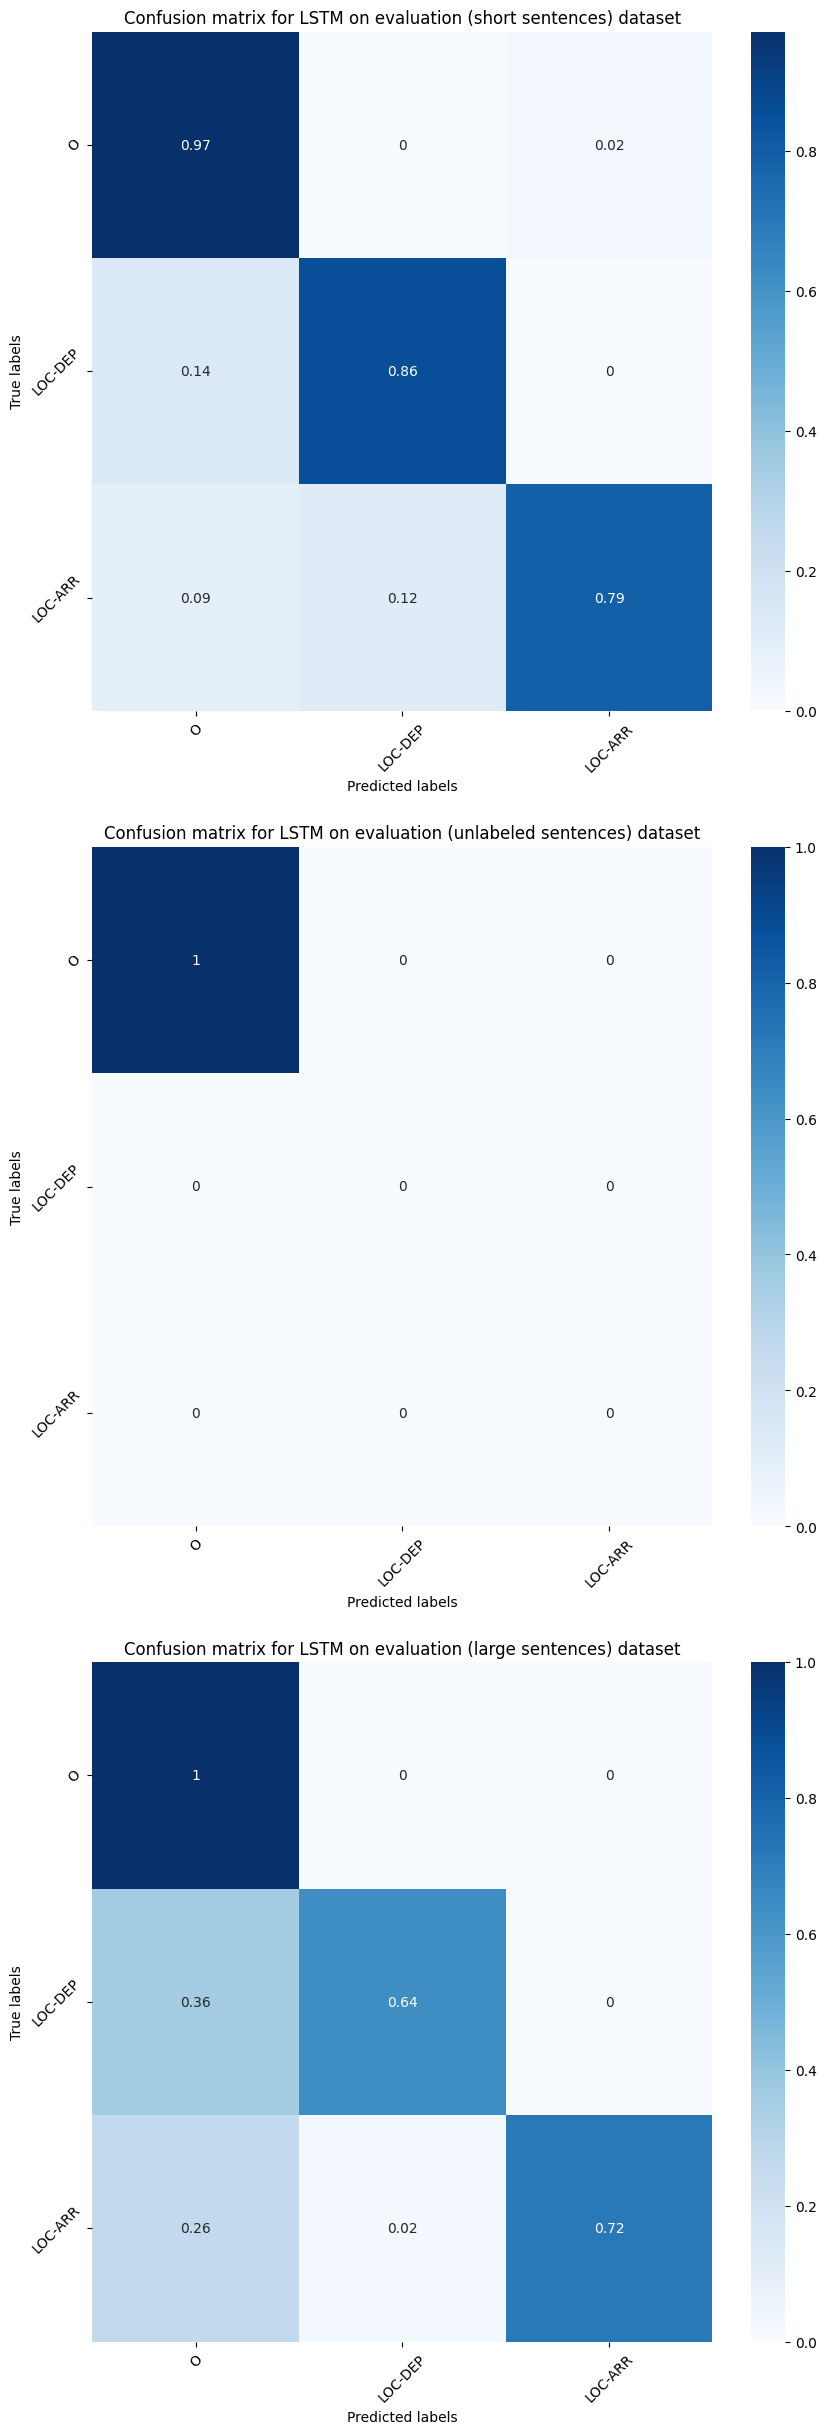

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(10, 30))

confusion_matrix(
    padded_eval_short_labels,
    eval_short_predictions,
    unique_labels,
    title="Confusion matrix for LSTM on evaluation (short sentences) dataset",
    return_ax=True,
    ax=axs[0],
)

confusion_matrix(
    padded_eval_unlabeled_labels,
    eval_unlabeled_predictions,
    unique_labels,
    title="Confusion matrix for LSTM on evaluation (unlabeled sentences) dataset",
    return_ax=True,
    ax=axs[1],
)

confusion_matrix(
    padded_eval_large_labels,
    eval_large_predictions,
    unique_labels,
    title="Confusion matrix for LSTM on evaluation (large sentences) dataset",
    return_ax=True,
    ax=axs[2],
)

plt.show()

In [29]:
def predict(
    sentence: str,
    model: tf.keras.Model,
    vocab: list[str] = vocab,
    max_len: int = MAX_LEN,
):
    """
    Predict the labels for a given sentence.

    Parameters:
    sentence (str): The sentence to predict.
    model (tf.keras.Model): The trained model.
    vocab (list): The vocabulary.
    max_len (int): The maximum length of the sentence.

    Returns:
    list: The predicted labels.
    """
    processed_sentence = dp.process_sentence(
        sentence, stemming=True, return_tokens=True
    )

    unstemmed_sentence = dp.process_sentence(
        sentence, stemming=False, return_tokens=True
    )

    encoded_sentence = encode_and_pad_sentence(processed_sentence, vocab, max_len)

    prediction = model.predict(tf.convert_to_tensor([encoded_sentence]))

    for word, label in zip(
        unstemmed_sentence, tf.math.argmax(prediction, axis=-1)[0].numpy()
    ):
        print(f"{word}: {list(unique_labels.keys())[label]}")

    return prediction

In [30]:
test_sentence = "Je veux prendre un vol de Montpellier à Paris."

test_pred = predict(test_sentence, lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Je: O
veux: O
prendre: O
un: O
vol: O
de: O
Montpellier: LOC-DEP
à: O
Paris: LOC-ARR
.: O


In [31]:
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 3)         │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,111 (6.65 MB)

 Trainable params: 580,703 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,161,408 (4.43 MB)

### Conclusion of using LSTM

The limitation of a simple LSTM is that the inputs are treated **sequentially**. Which means that it does not benefit from the context of the words that comes after, only what comes before. Therefore, we will try the **BiLSTM model** hoping that treating the sentence from both sides will leverage more context.


## BiLSTM

As mentioned in the previous section, we will be testing a **Bidirectional LSTM** model in order to improve performance.


![](./assets/bi-lstm.png)


In [32]:
bilstm = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Embedding(len(vocab) + 1, MAX_LEN, mask_zero=True),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(MAX_LEN, return_sequences=True)
        ),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(unique_labels), activation=tf.nn.log_softmax),
    ]
)

In [33]:
bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=masked_loss,
    metrics=[masked_accuracy],
)

In [34]:
bilstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
bilstm.fit(
    train_dataset.batch(64),
    validation_data=test_dataset.batch(64),
    epochs=10,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=0.01, restore_best_weights=True
        )
    ],
)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - loss: 0.1819 - masked_accuracy: 0.9388 - val_loss: 0.0029 - val_masked_accuracy: 0.9996
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - loss: 0.0022 - masked_accuracy: 0.9995 - val_loss: 0.0043 - val_masked_accuracy: 0.9985


In [36]:
blstm_eval_short_predictions = bilstm.predict(encoded_eval_short_sentences)
blstm_eval_unlabeled_predictions = bilstm.predict(encoded_eval_unlabeled_sentences)
blstm_eval_large_predictions = bilstm.predict(encoded_eval_large_sentences)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [37]:
print(type(blstm_eval_short_predictions))

<class 'numpy.ndarray'>


In [38]:
print(
    "Eval short sentences accuracy: ",
    masked_accuracy(padded_eval_short_labels, blstm_eval_short_predictions).numpy(),
)

print(
    "Eval unlabeled sentences accuracy: ",
    masked_accuracy(
        padded_eval_unlabeled_labels, blstm_eval_unlabeled_predictions
    ).numpy(),
)

print(
    "Eval large sentences accuracy: ",
    masked_accuracy(padded_eval_large_labels, blstm_eval_large_predictions).numpy(),
)

Eval short sentences accuracy:  0.9559666
Eval unlabeled sentences accuracy:  0.9990983
Eval large sentences accuracy:  0.9832926


In [39]:
print(
    "Eval short sentences tag accuracy: ",
    entity_accuracy(padded_eval_short_labels, blstm_eval_short_predictions).numpy(),
)

print(
    "Eval large sentences tag accuracy: ",
    entity_accuracy(padded_eval_large_labels, blstm_eval_large_predictions).numpy(),
)

tf.Tensor(1429.0, shape=(), dtype=float32)
tf.Tensor(1682.0, shape=(), dtype=float32)
Eval short sentences tag accuracy:  0.8495838
tf.Tensor(150.0, shape=(), dtype=float32)
tf.Tensor(219.0, shape=(), dtype=float32)
Eval large sentences tag accuracy:  0.6849315


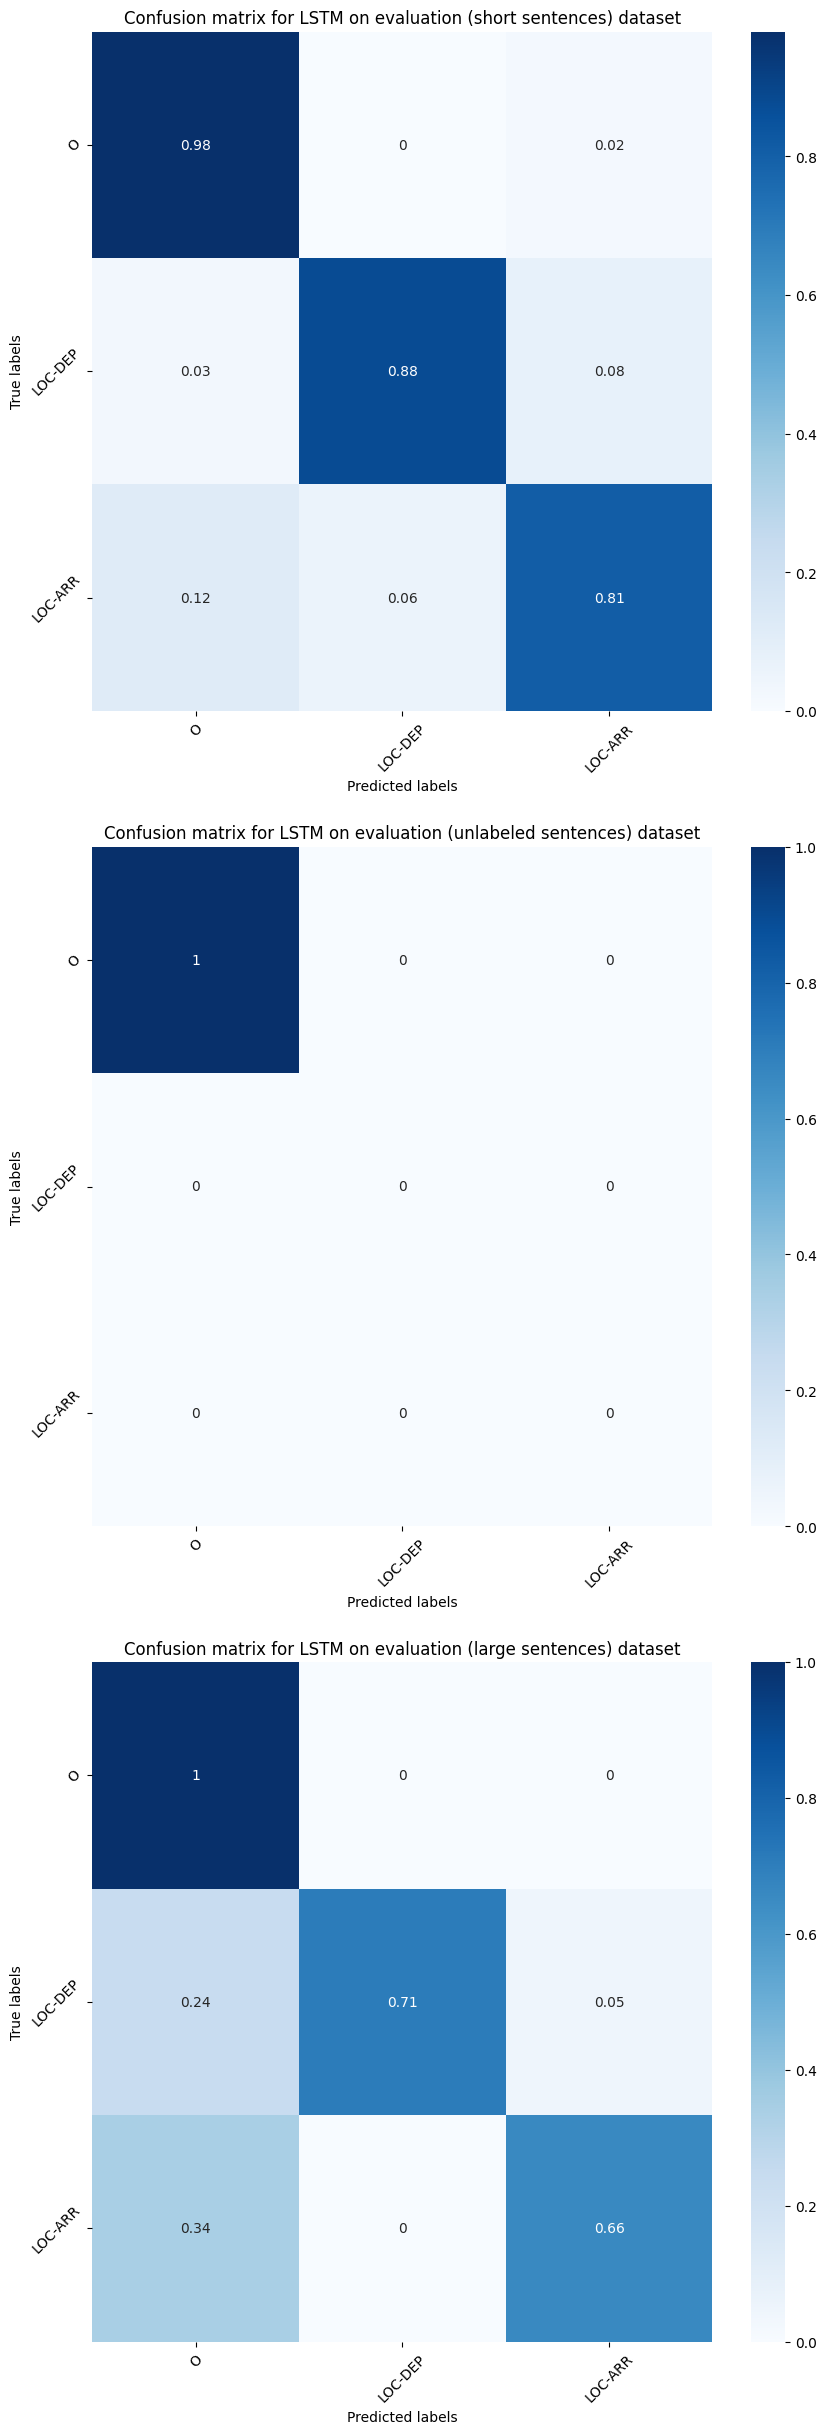

In [40]:
fig, axs = plt.subplots(3, 1, figsize=(10, 30))

confusion_matrix(
    padded_eval_short_labels,
    blstm_eval_short_predictions,
    unique_labels,
    title="Confusion matrix for LSTM on evaluation (short sentences) dataset",
    return_ax=True,
    ax=axs[0],
)

confusion_matrix(
    padded_eval_unlabeled_labels,
    blstm_eval_unlabeled_predictions,
    unique_labels,
    title="Confusion matrix for LSTM on evaluation (unlabeled sentences) dataset",
    return_ax=True,
    ax=axs[1],
)

confusion_matrix(
    padded_eval_large_labels,
    blstm_eval_large_predictions,
    unique_labels,
    title="Confusion matrix for LSTM on evaluation (large sentences) dataset",
    return_ax=True,
    ax=axs[2],
)

plt.show()

In [41]:
test_sentence = "Je pensais partir de Bangkok. Mais finalement, je vais devoir trouver un voyage de Tokyo vers Osaka."



p = predict(test_sentence, lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Je: O
pensais: O
partir: O
de: O
Bangkok: LOC-DEP
.: O
Mais: O
finalement: O
,: O
je: O
vais: O
devoir: O
trouver: O
un: O
voyage: O
de: O
Tokyo: LOC-DEP
vers: O
Osaka: LOC-ARR
.: O


In [42]:
vocab[4368]

'quelques-un'

## Prediction Analysis


In [44]:
from tqdm import tqdm
import pandas as pd
import numpy as np


def mask_predictions(predictions: np.ndarray, labels: np.ndarray, mask=-1):
    """
    Mask the predictions based on the labels.

    Parameters:
    predictions (tensor): Predicted logits.
    labels (tensor): True labels.
    mask (int): Mask value.

    Returns:
    masked_predictions (tensor): Masked predictions.
    """

    # Perform argmax to get the predicted values
    predictions_class = np.argmax(predictions, axis=-1)

    # Create the mask based on the mask in the labels
    mask = np.where(labels == mask, mask, 0)
    return predictions_class + mask


def get_mistakes_positions(predictions, labels):
    masked_predictions = mask_predictions(predictions, labels)
    wrong_predictions = np.where(masked_predictions != labels, masked_predictions, -2)
    return wrong_predictions


def label_pos_freq_in_sentences(
    labels,
    unique_labels,
    title="Sentences labels heatmap",
    skip_zero_positions=False,
    max_len=None,
):
    """
    Generate a heatmap of the sentences and their labels.

    Parameters:
    labels (list): List of labels in a sentence (it could be predictions)
    unique_labels (list): List of unique labels.
    title (str): Title of the plot.
    """
    positions_label_counts = {}

    for label in tqdm(labels):
        length = max_len if max_len else len(label)
        for i in range(length):
            # skip padding
            if label[i] not in unique_labels.values() and not label[i] == -2:
                continue
            if i not in positions_label_counts:
                positions_label_counts[i] = {}
                for l in unique_labels.values():
                    positions_label_counts[i][l] = 0
            if label[i] == -2:
                continue
            positions_label_counts[i][label[i]] += 1

    # Filter out positions where the sum of label counts is zero
    hm_data = {
        k: v
        for k, v in positions_label_counts.items()
        if skip_zero_positions and sum(list(v.values())) > 0 or not skip_zero_positions
    }
    hm_data = pd.DataFrame(hm_data)

    # dtype conversion
    hm_data = hm_data.astype(float)
    hm_data.set_index(pd.Index(unique_labels.keys()), inplace=True)

    # normalizing the data per column
    hm_data = hm_data.div(hm_data.sum(axis=0), axis=1)

    plt.figure(figsize=(20, 10))

    sns.heatmap(hm_data, cmap="Blues")

    plt.title(title)

    plt.show()

100%|██████████| 757/757 [00:00<00:00, 3104.51it/s]


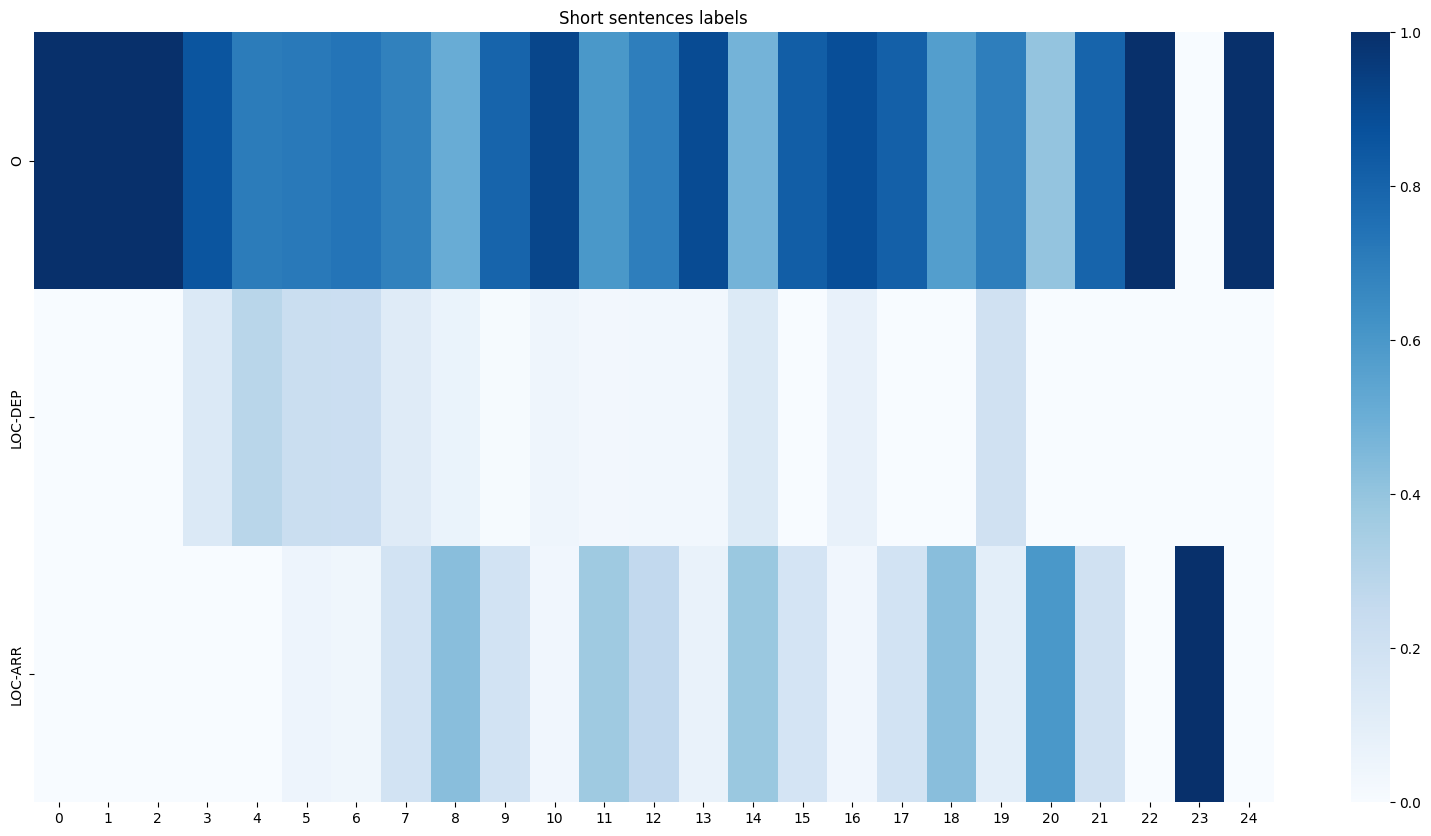

In [45]:
label_pos_freq_in_sentences(
    padded_eval_short_labels, unique_labels, title="Short sentences labels"
)

100%|██████████| 757/757 [00:00<00:00, 37226.10it/s]


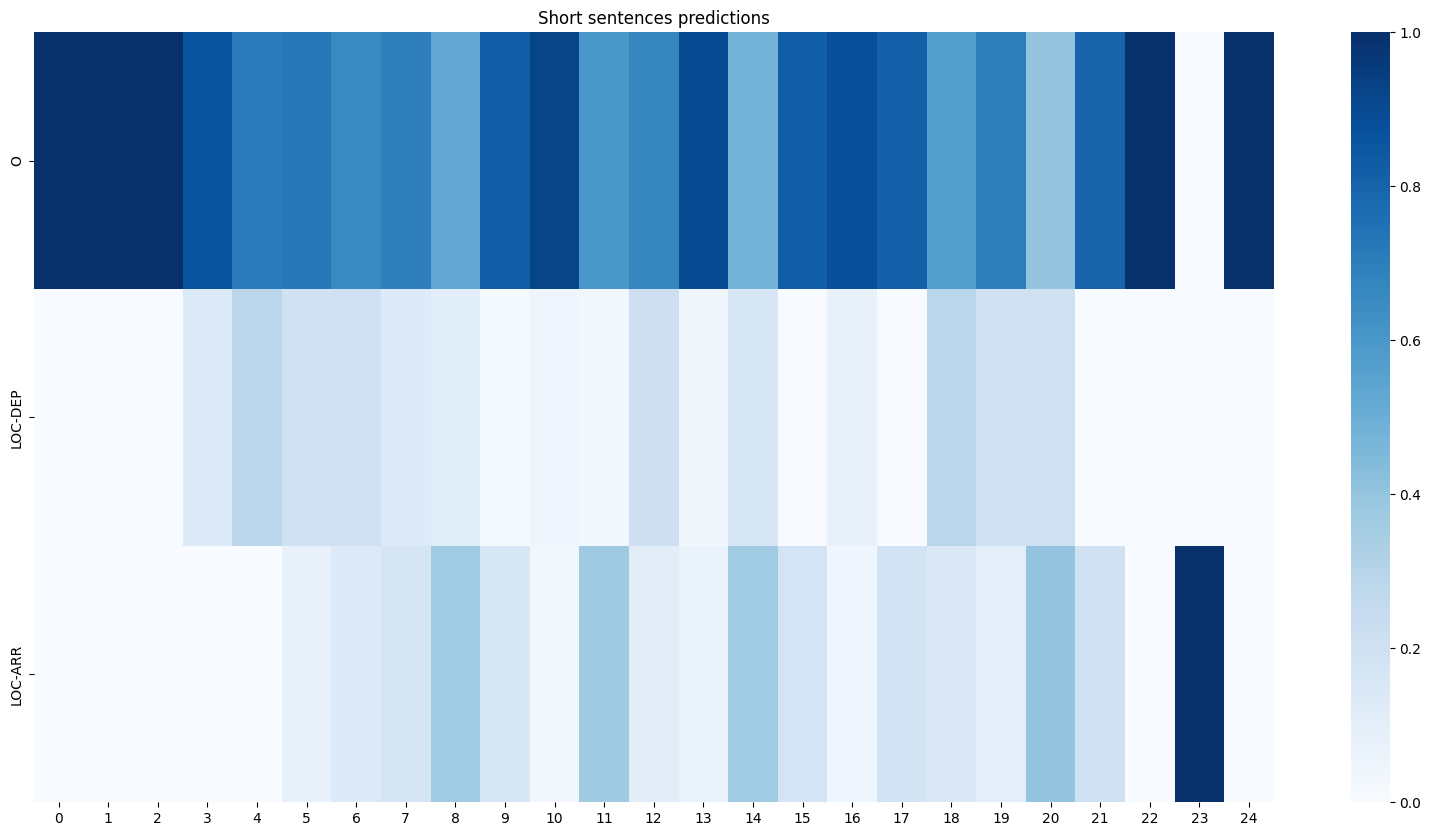

In [46]:
label_pos_freq_in_sentences(
    mask_predictions(blstm_eval_short_predictions, padded_eval_short_labels),
    unique_labels,
    title="Short sentences predictions",
)

100%|██████████| 757/757 [00:00<00:00, 71340.68it/s]


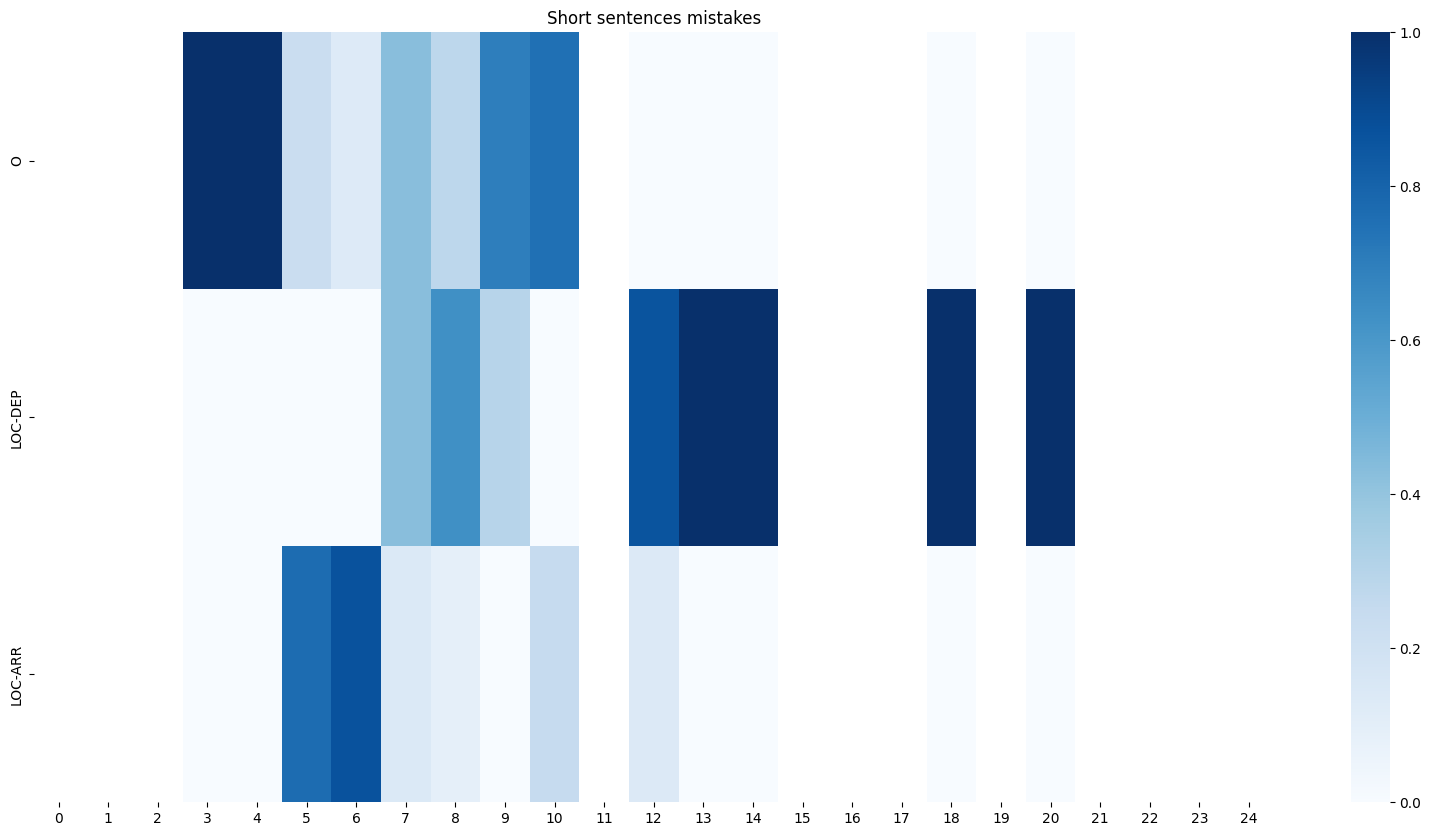

In [47]:
label_pos_freq_in_sentences(
    get_mistakes_positions(blstm_eval_short_predictions, padded_eval_short_labels),
    unique_labels,
    title="Short sentences mistakes",
    max_len=25,
)

100%|██████████| 95/95 [00:00<00:00, 763.16it/s]


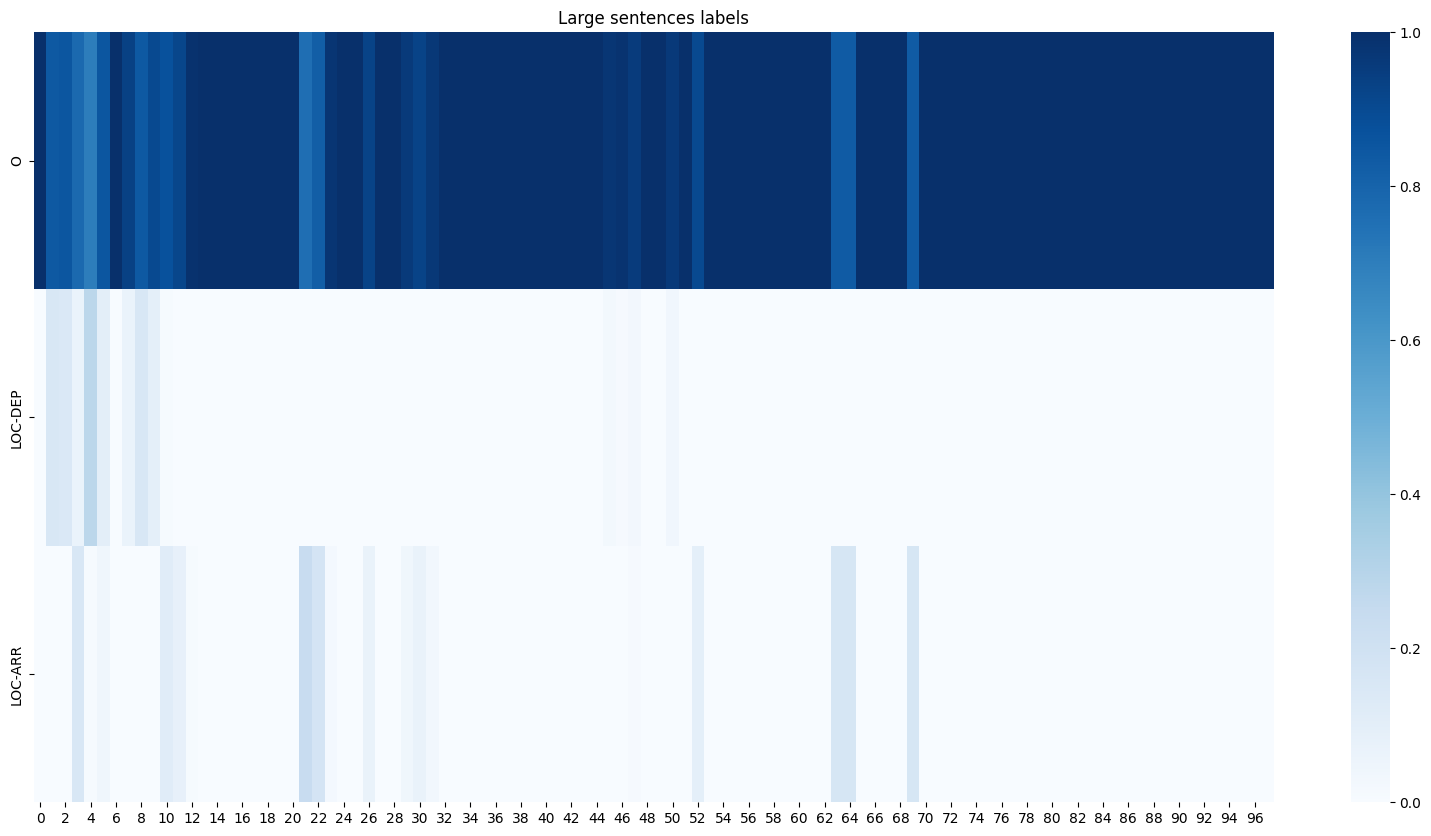

In [48]:
label_pos_freq_in_sentences(
    padded_eval_large_labels, unique_labels, title="Large sentences labels"
)

100%|██████████| 95/95 [00:00<00:00, 26765.56it/s]


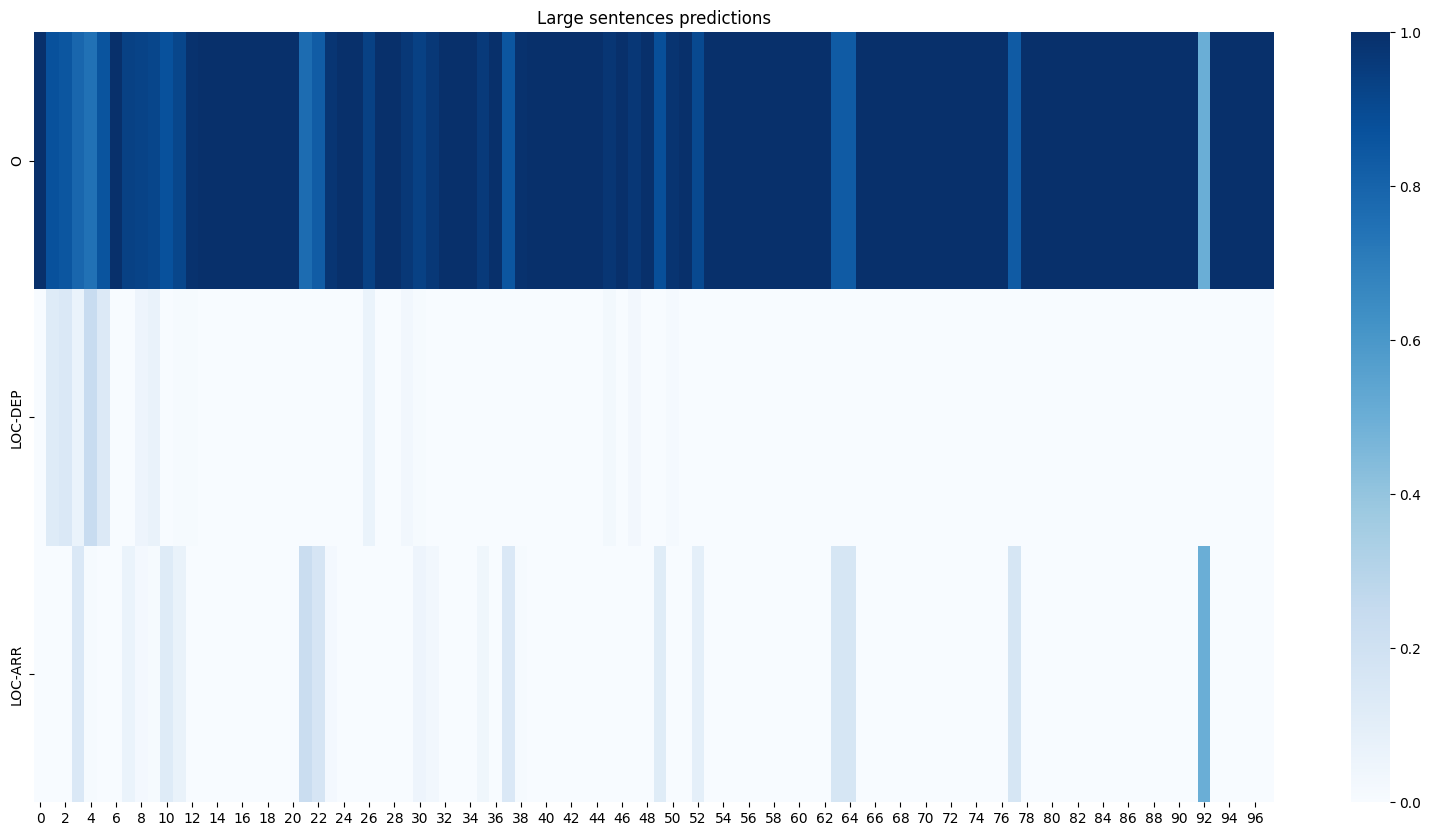

In [49]:
label_pos_freq_in_sentences(
    mask_predictions(blstm_eval_large_predictions, padded_eval_large_labels),
    unique_labels,
    title="Large sentences predictions",
)

100%|██████████| 95/95 [00:00<00:00, 25614.48it/s]


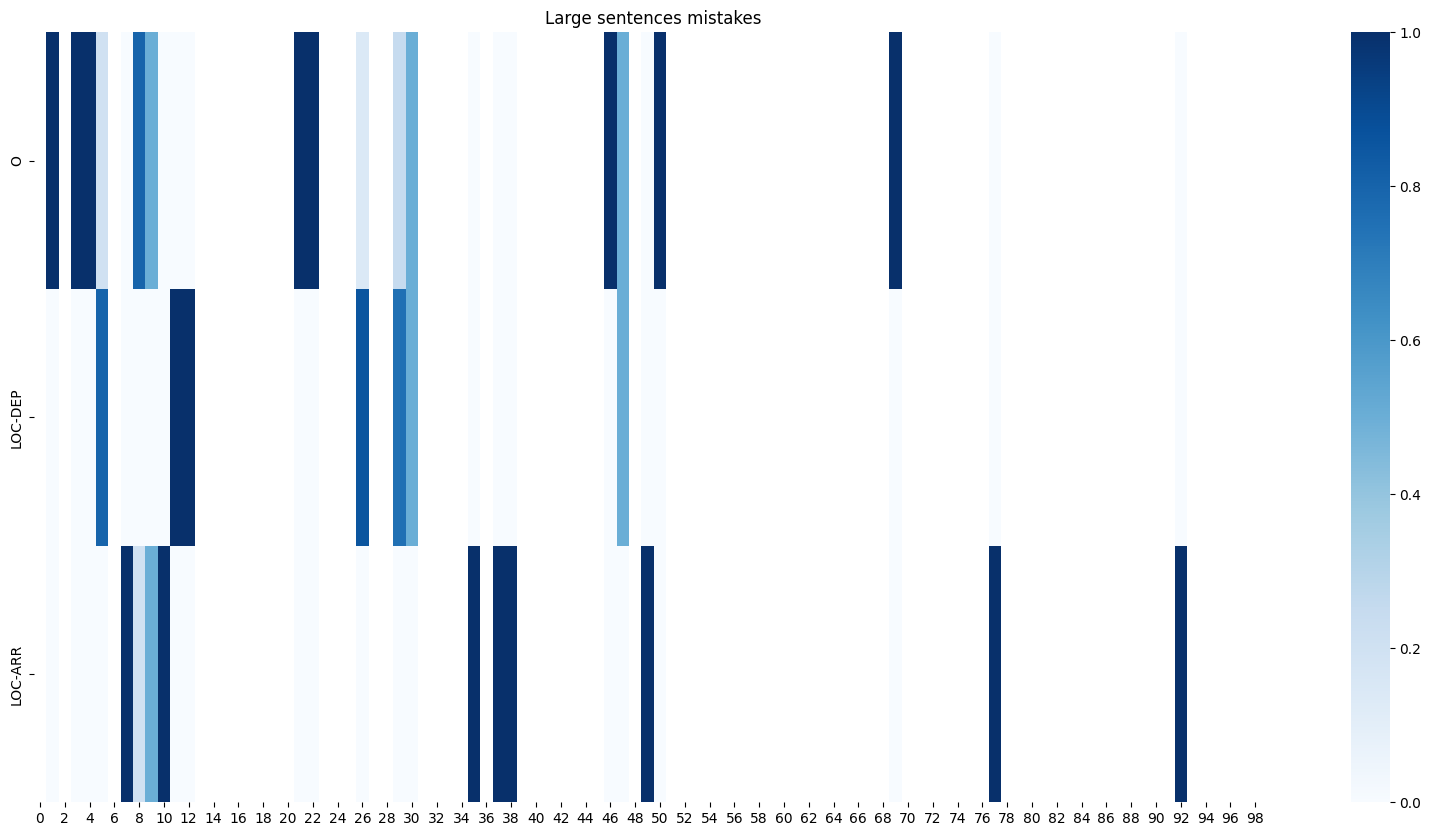

In [50]:
label_pos_freq_in_sentences(
    get_mistakes_positions(blstm_eval_large_predictions, padded_eval_large_labels),
    unique_labels,
    title="Large sentences mistakes",
    skip_zero_positions=False,
)